In [1]:
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

/nas/longleaf/home/aryonna/488FinalProject/final_proj_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%pwd

In [2]:
df = pd.read_csv('../Labeled_Df.csv')

In [3]:
df = df.drop(columns=['label'])


In [ ]:
df.head(4)

In [4]:
# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

<Axes: >

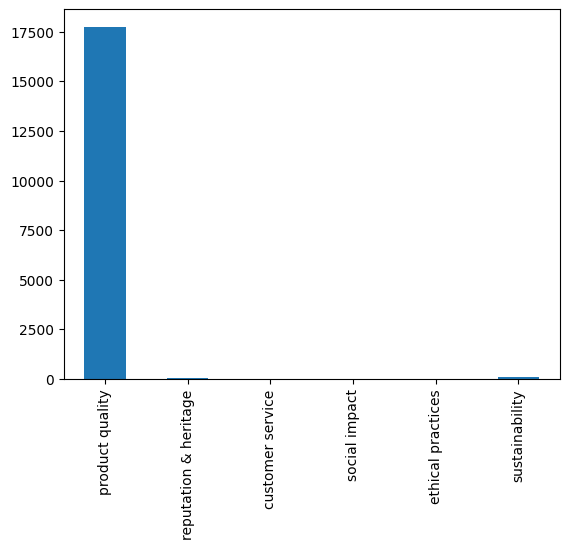

In [5]:
train_df[train_df.columns[1:]].sum().plot.bar()

In [ ]:
%pwd

In [6]:
%cd ..

/nas/longleaf/home/aryonna/488FinalProject


/nas/longleaf/home/aryonna/488FinalProject/final_proj_env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
from datasetss.brand_perception_dataset import BrandPerceptionDataset
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
brand_perception_ds = BrandPerceptionDataset(train_df, tokenizer)
brand_perception_val_ds = BrandPerceptionDataset(val_df, tokenizer)

In [8]:
brand_perception_ds.__getitem__(0)

{'input_ids': tensor([   0, 2678,   37, 7628, 9084,  102,    2,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [9]:
from brand_perception_data_module import BrandPerceptionDataModule
brand_perception_dm = BrandPerceptionDataModule(train_df, val_df)

In [10]:
brand_perception_dm.setup()

In [11]:
brand_perception_dm.train_dataloader()

In [12]:
len(brand_perception_dm.train_dataloader())

1171

In [13]:
from modules.BrandPerceptionModel import BrandPerceptionModel
config = {
    'model_name': 'SamLowe/roberta-base-go_emotions',
    'n_labels_bp': 6,
    'batch_size': 128,
    'lr': 1.5e-6,
    'warmup': 0.2, 
    'train_size': len(brand_perception_dm.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 100
}
model = BrandPerceptionModel(config)

Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
idx=0
input_ids = brand_perception_ds.__getitem__(idx)['input_ids']
attention_mask = brand_perception_ds.__getitem__(idx)['attention_mask']
labels = brand_perception_ds.__getitem__(idx)['labels']
model.cpu()
loss, aspect_logits, emotion_logits = model(input_ids.unsqueeze(dim=0), attention_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))
print(labels.shape, aspect_logits.shape, aspect_logits)

torch.Size([6]) torch.Size([1, 28]) tensor([[-6.9223e-01, -1.0047e-01, -3.7235e-01, -9.1112e-02,  1.9346e-01,
         -3.1137e-01,  1.4725e-01, -8.4836e-04, -2.4117e-01,  2.4672e-01,
          1.3300e-01, -9.6290e-01, -1.0880e-02,  5.1774e-01,  1.2050e-01,
          6.0621e-01,  5.1904e-01, -9.0601e-02,  4.0719e-01, -1.7518e-01,
          9.1586e-01,  4.0131e-01,  1.5336e-01,  3.0630e-01,  3.3314e-01,
          6.0772e-02, -2.6575e-01,  4.3501e-01]], grad_fn=<AddmmBackward0>)


In [15]:
import pytorch_lightning as pl
trainer = pl.Trainer(max_epochs=config['n_epochs'], num_sanity_val_steps=50)
trainer.fit(model, brand_perception_dm)


/nas/longleaf/home/aryonna/488FinalProject/final_proj_env/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nas/longleaf/home/aryonna/488FinalProject/final_pro ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nas/longleaf/home/aryonna/488FinalProject/final_proj_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. P

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch 0:   7%|▋         | 87/1171 [14:46<3:04:03,  0.10it/s, v_num=2, train_loss_step=0.634]

/nas/longleaf/home/aryonna/488FinalProject/final_proj_env/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
print(train_df)